# Diamonds

## Импорты библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('diamonds.csv')
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


![Скриншот 24-09-2025 182347.jpg](<attachment:Скриншот 24-09-2025 182347.jpg>)
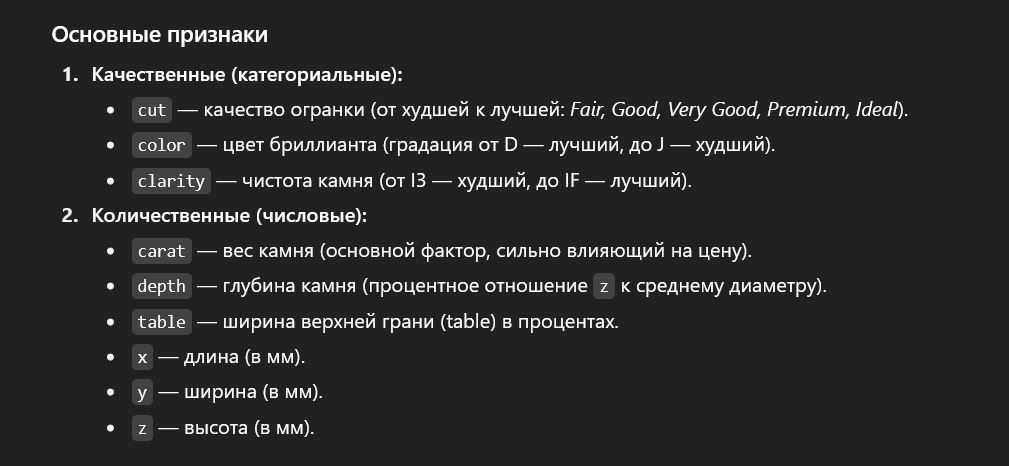

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


- всего 53940 значений
- нет пропусков
- типы данных соответствуют

In [4]:
df.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


- __carat__: минимальное значение = 0.2, максимальное = 5, среднее ~ 0.8, подталкивает на мысль, что есть выбросы
- __depth__: минимальное значение = 43, максимальное = 79, среднее и медиана примерно равны между собой - возможно нормальное распределение
- __table__: ситуация, как с __depth__
- __x__, __y__, __z__ минимальные значения равны 0, возможно, здесь ошибка, распределения похожи на нормальные
- целевая переменная __price__: распределение не похоже на нормальное

## Работа с числовыми признаками

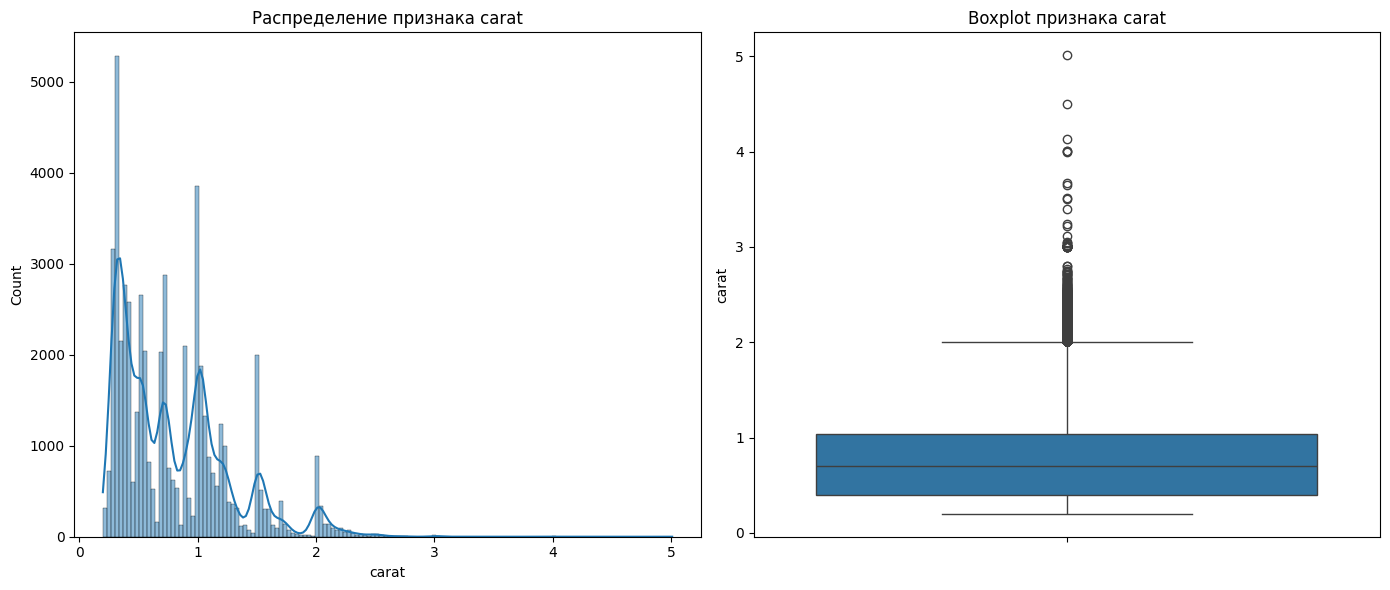

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df['carat'], kde=True, ax=axes[0])
axes[0].set_title('Распределение признака carat')

sns.boxplot(df['carat'], ax=axes[1])
axes[1].set_title('Boxplot признака carat')

plt.tight_layout()
plt.show()

Как я и говорил, очень много выбросов, распределение скошено вправо, применим к данному признаку логарифмирование и срез по 95 квантилю

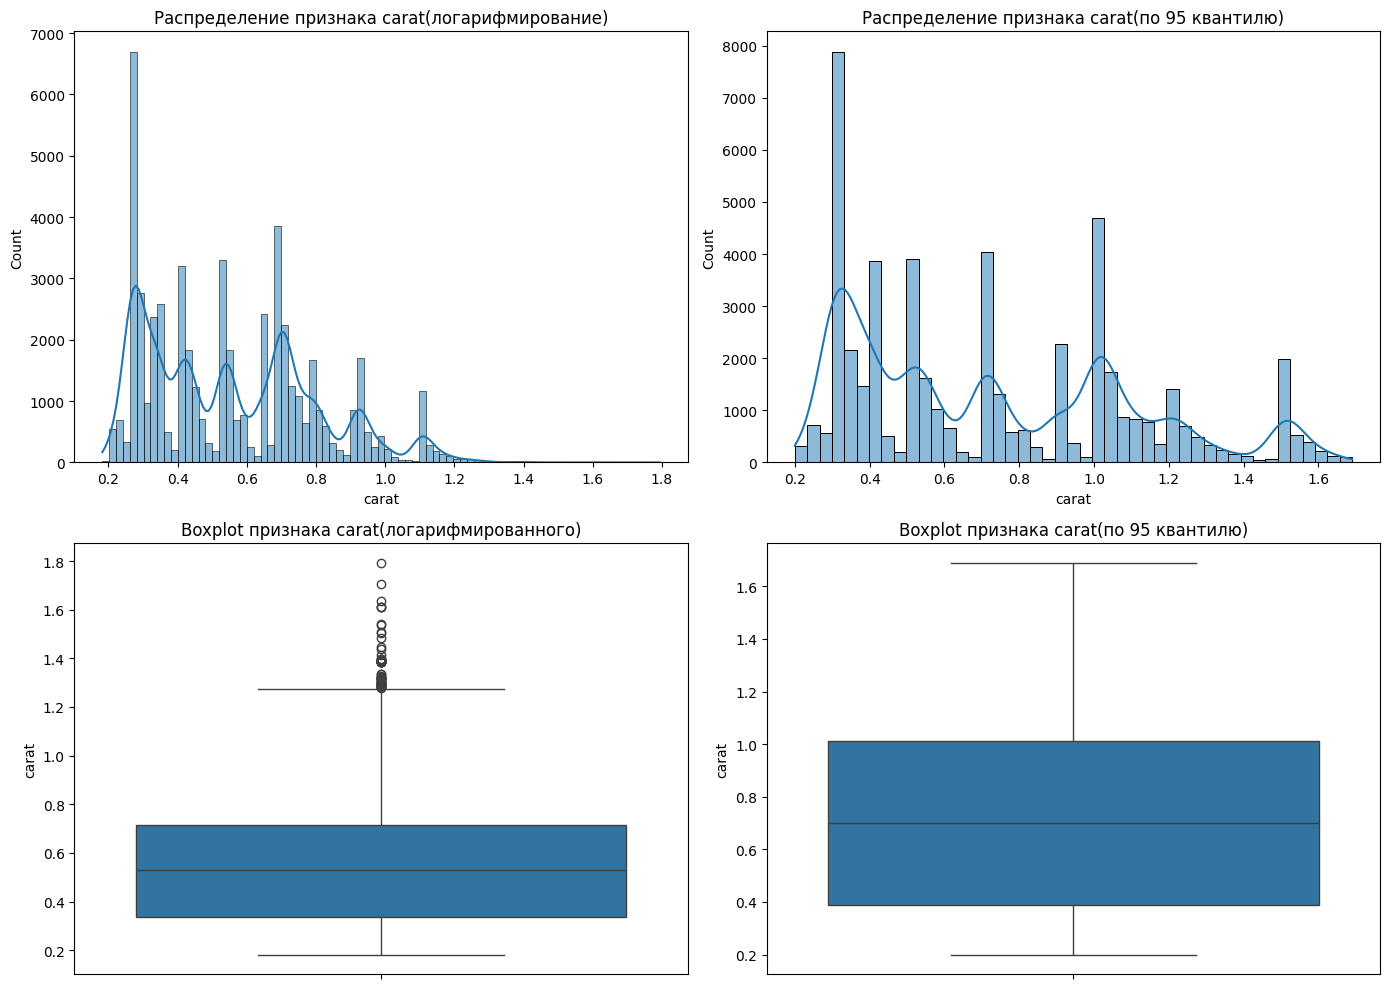

In [6]:
p95 = df['carat'].quantile(0.95)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(np.log1p(df['carat']), kde=True, ax=axes[0,0])
axes[0,0].set_title('Распределение признака carat(логарифмирование)')

sns.boxplot(np.log1p(df['carat']), ax=axes[1, 0])
axes[1, 0].set_title('Boxplot признака carat(логарифмированного)')

sns.histplot(df['carat'][df['carat'] < p95], kde=True, ax=axes[0,1])
axes[0,1].set_title('Распределение признака carat(по 95 квантилю)')

sns.boxplot(df['carat'][df['carat'] < p95], ax=axes[1, 1])
axes[1, 1].set_title('Boxplot признака carat(по 95 квантилю)')

plt.tight_layout()
plt.show()

Лучше с данным распределением справился срез по 95 квантилю - выбросов не стало


Заметил ещё такую интересную вещь - распределение идёт "волнами", сейчас попробую создать новые признак - категория веса камня(очень легкий, легкий, средний, тяжёлый), и сгруппирую по целевому признаку

In [7]:
df['cat_carat'] = pd.cut(df['carat'], bins=[0.2, 0.67, 0.87, 1.4, 5.01], labels=['very_light', 'light', 'sredniy', 'heavy'])

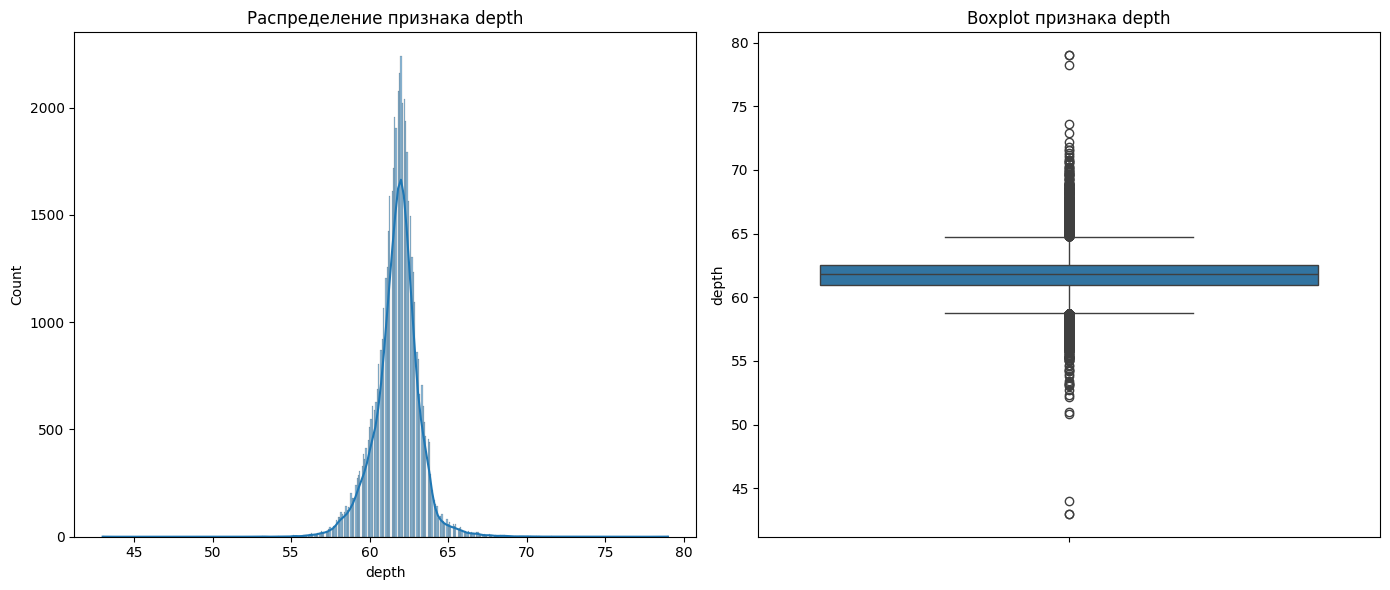

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df['depth'], kde=True, ax=axes[0])
axes[0].set_title('Распределение признака depth')

sns.boxplot(df['depth'], ax=axes[1])
axes[1].set_title('Boxplot признака depth')

plt.tight_layout()
plt.show()

Распределение похоже на нормальное, но есть очень много выбросов, оставим этот признак, как есть 

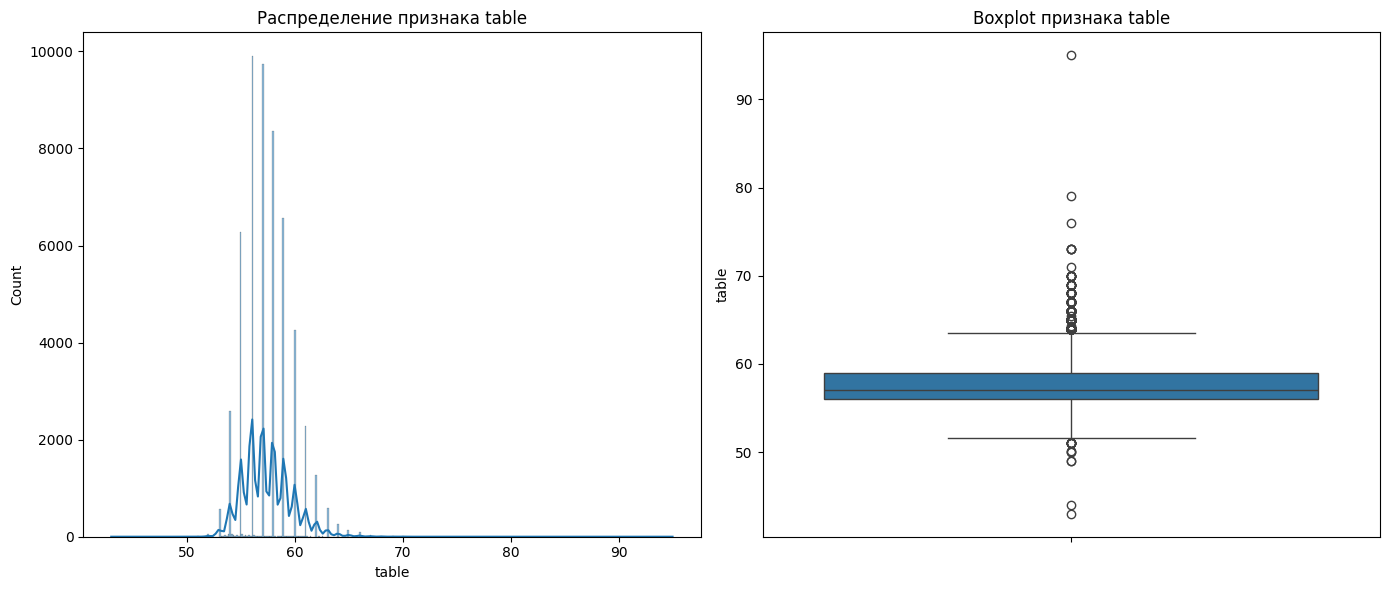

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df['table'], kde=True, ax=axes[0])
axes[0].set_title('Распределение признака table')

sns.boxplot(df['table'], ax=axes[1])
axes[1].set_title('Boxplot признака table')

plt.tight_layout()
plt.show()

Вот здесь уже не похоже на нормальное распределение, хотя boxplot похож на нормальное распределение, оставим этот признак тоже как есть

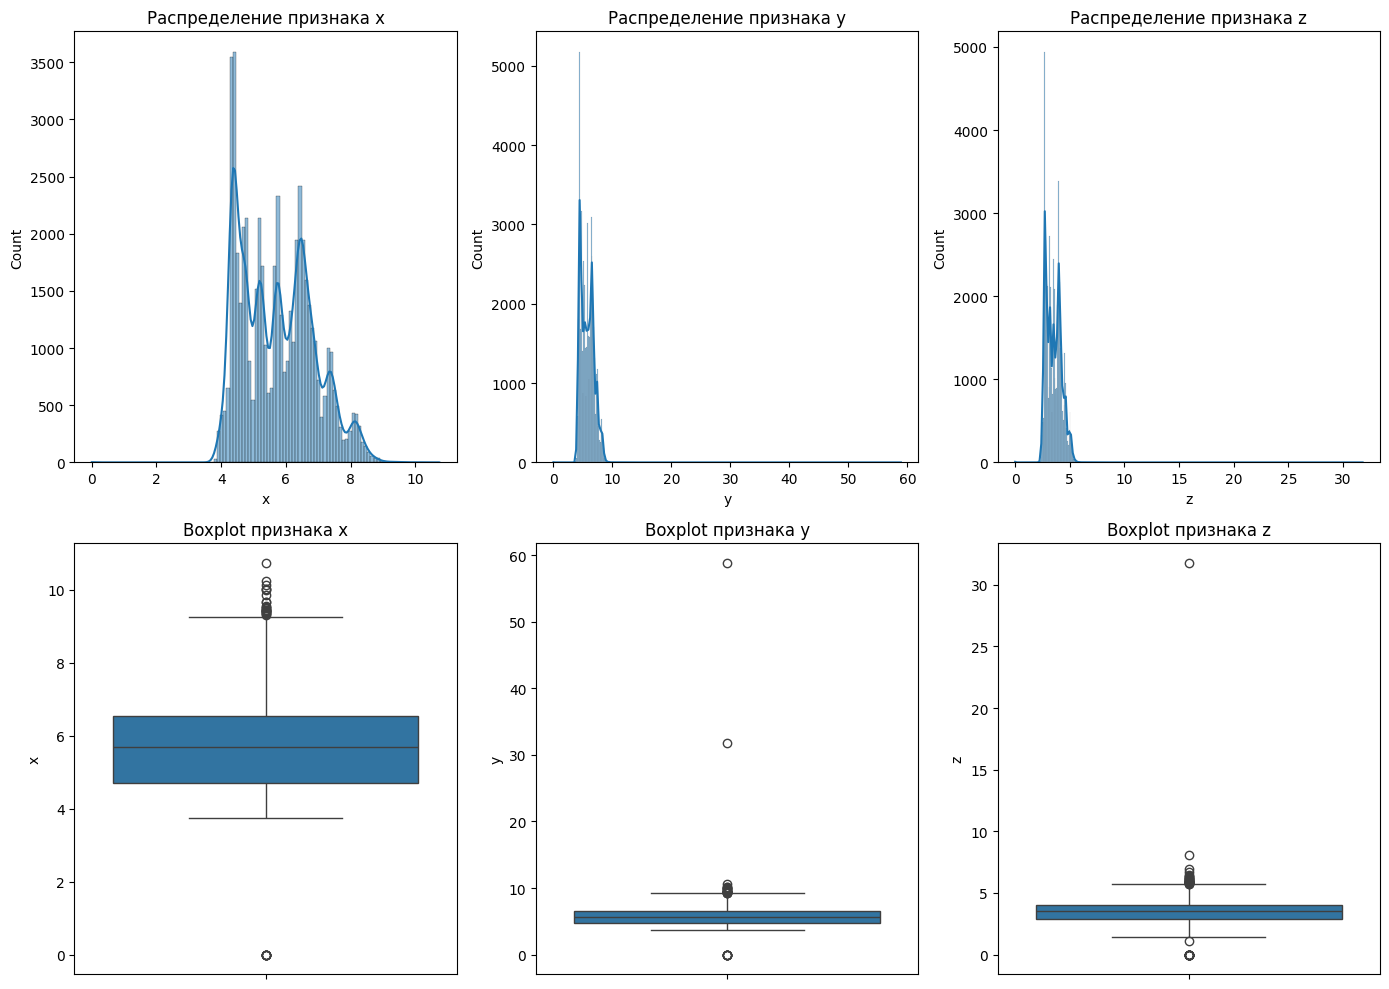

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

sns.histplot(df['x'], kde=True, ax=axes[0,0])
axes[0,0].set_title('Распределение признака x')

sns.boxplot(df['x'], ax=axes[1,0])
axes[1,0].set_title('Boxplot признака x')

sns.histplot(df['y'], kde=True, ax=axes[0,1])
axes[0,1].set_title('Распределение признака y')

sns.boxplot(df['y'], ax=axes[1,1])
axes[1,1].set_title('Boxplot признака y')

sns.histplot(df['z'], kde=True, ax=axes[0,2])
axes[0,2].set_title('Распределение признака z')

sns.boxplot(df['z'], ax=axes[1,2])
axes[1, 2].set_title('Boxplot признака z')

plt.tight_layout()
plt.show()

- Не одно распределение не похоже на нормальное
- Признак x я бы прологарифмировал
- Признаки y и z я бы сначала обрезал по 5 и 95 квантилю, а потом, возможно, тоже бы прологарифмировал

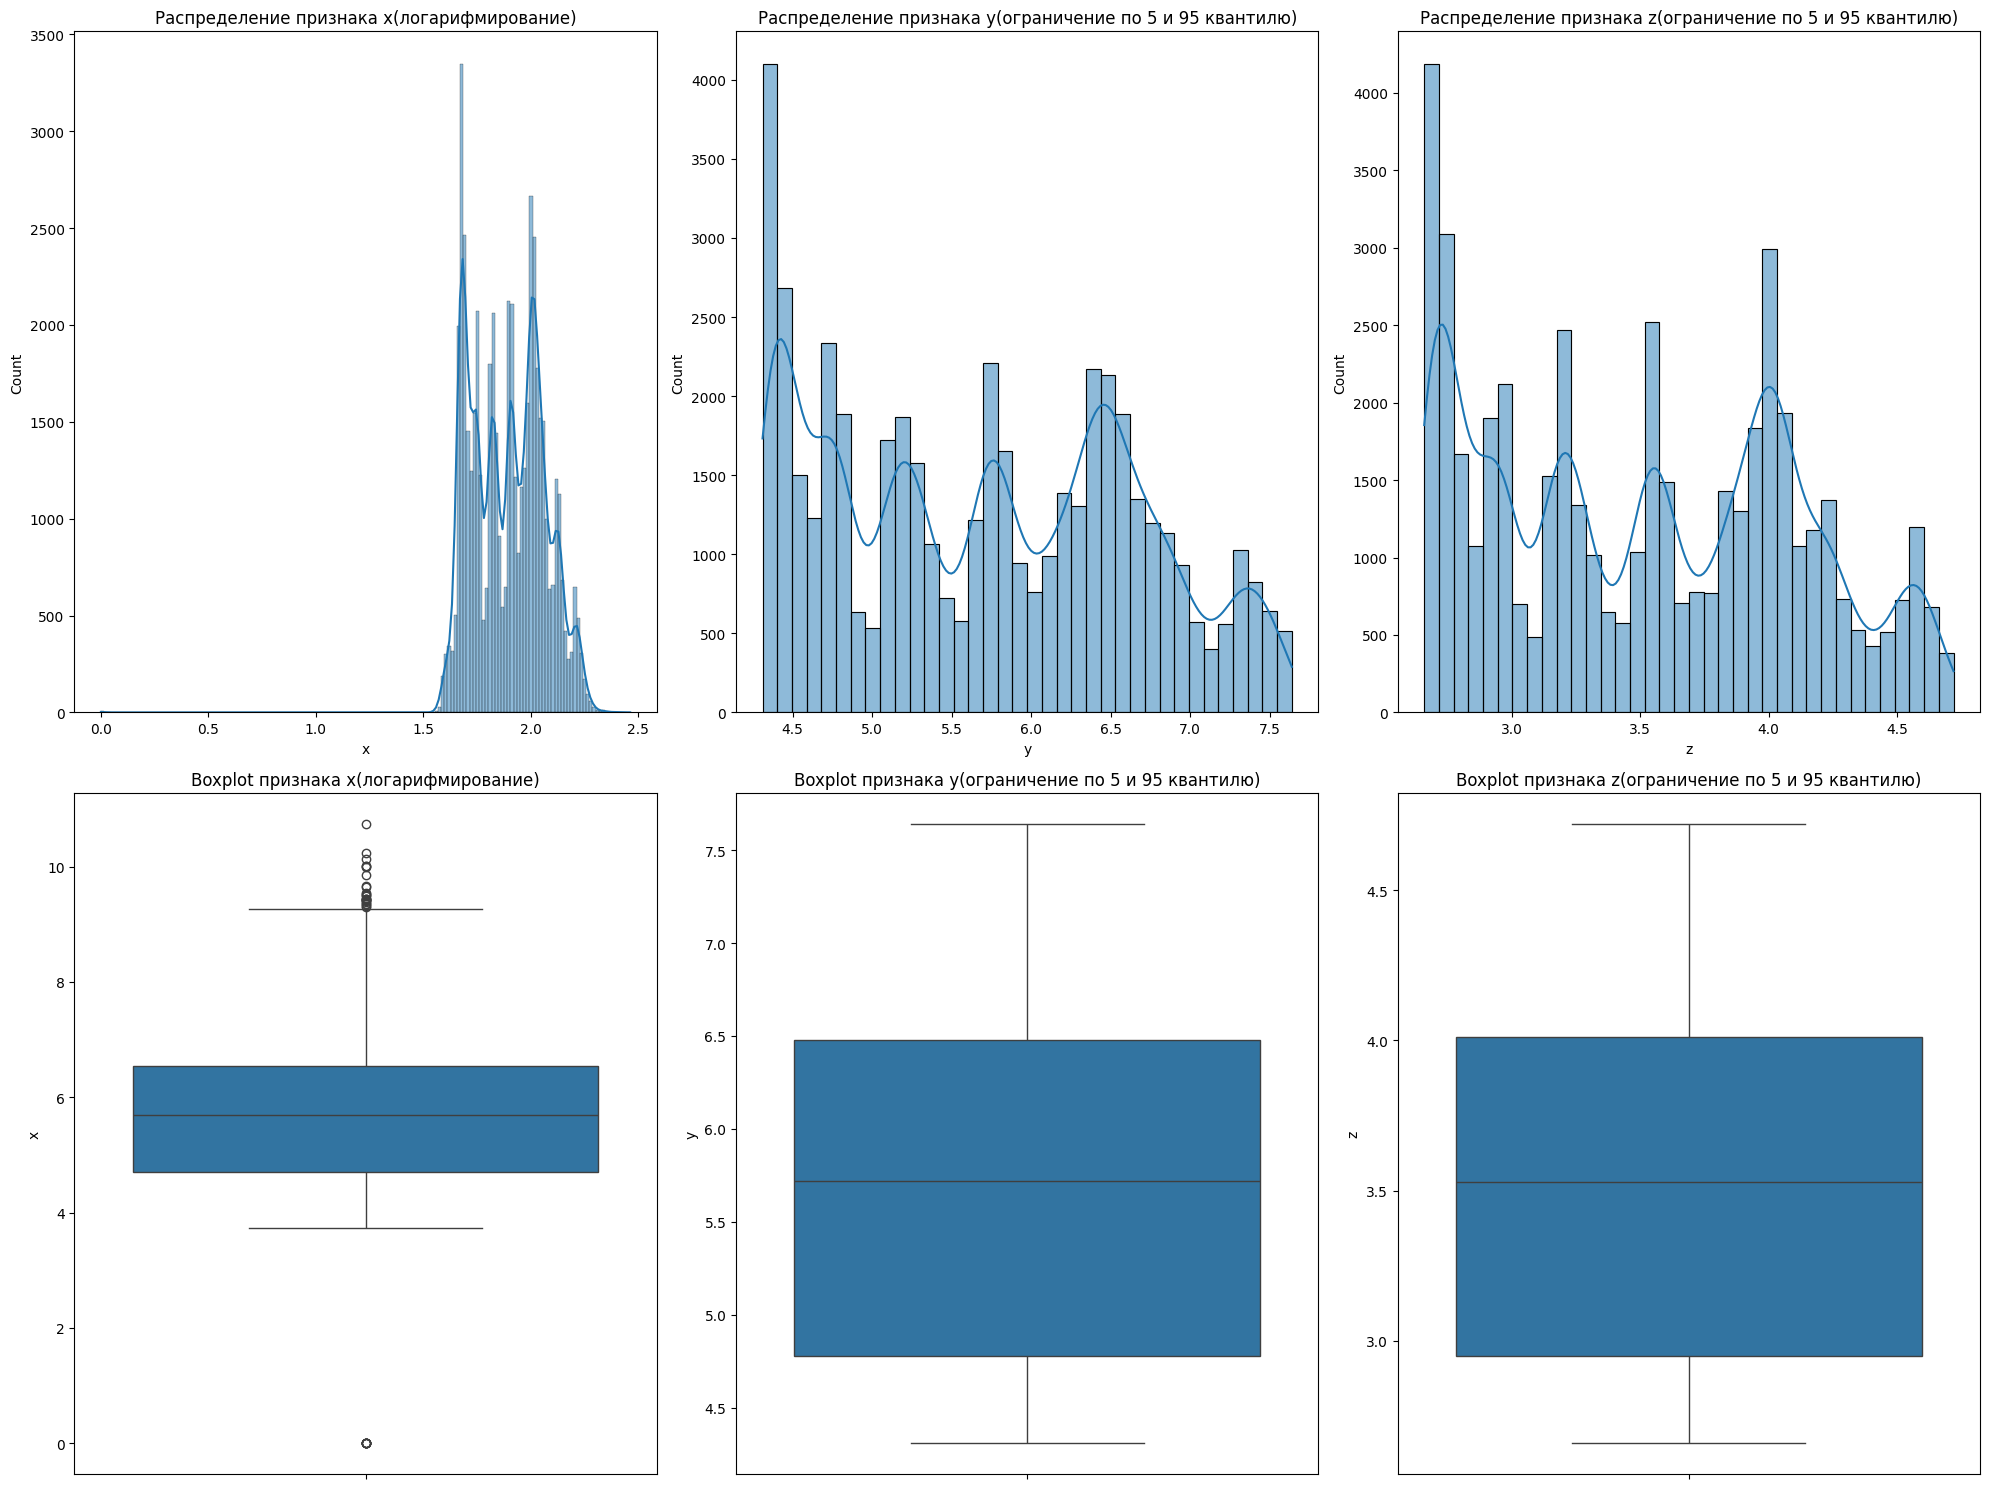

In [11]:
p95_y = df['y'].quantile(0.95)
p05_y = df['y'].quantile(0.05)
p95_z = df['z'].quantile(0.95)
p05_z = df['z'].quantile(0.05)

fig, axes = plt.subplots(2, 3, figsize=(20, 15))

sns.histplot(np.log1p(df['x']), kde=True, ax=axes[0,0])
axes[0,0].set_title('Распределение признака x(логарифмирование)')

sns.boxplot(df['x'], ax=axes[1,0])
axes[1,0].set_title('Boxplot признака x(логарифмирование)')

sns.histplot(df['y'][(df['y']<p95_y) & (df['y']>p05_y)], kde=True, ax=axes[0,1])
axes[0,1].set_title('Распределение признака y(ограничение по 5 и 95 квантилю)')

sns.boxplot(df['y'][(df['y']<p95_y) & (df['y']>p05_y)], ax=axes[1,1])
axes[1,1].set_title('Boxplot признака y(ограничение по 5 и 95 квантилю)')

sns.histplot(df['z'][(df['z']<p95_z) & (df['z']>p05_z)], kde=True, ax=axes[0,2])
axes[0,2].set_title('Распределение признака z(ограничение по 5 и 95 квантилю)')

sns.boxplot(df['z'][(df['z']<p95_z) & (df['z']>p05_z)], ax=axes[1,2])
axes[1, 2].set_title('Boxplot признака z(ограничение по 5 и 95 квантилю)')

plt.tight_layout()
plt.show()

Логарифмирование признака x ничего не дало, а вот обрез по 5 и 95 квантилям признаков y и z показало очень хорошие результаты - я опять вижу "волны", как у признака __carat__

Обрежем признак x тоже по 5 и 95 квантилю

Text(0.5, 1.0, 'Boxplot признака x(ограничение по 5 и 95 квантилю)')

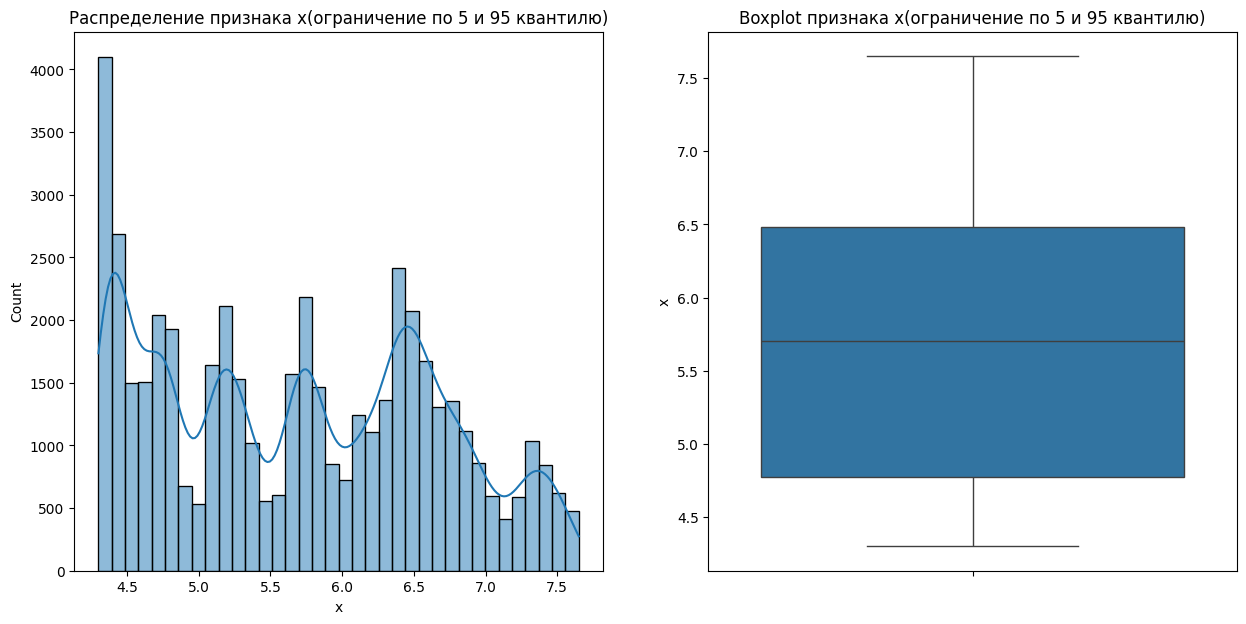

In [12]:
p95_x = df['x'].quantile(0.95)
p05_x = df['x'].quantile(0.05)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

sns.histplot(df['x'][(df['x']<p95_x) & (df['x']>p05_x)], kde=True, ax=axes[0])
axes[0].set_title('Распределение признака x(ограничение по 5 и 95 квантилю)')

sns.boxplot(df['x'][(df['x']<p95_x) & (df['x']>p05_x)], ax=axes[1])
axes[1].set_title('Boxplot признака x(ограничение по 5 и 95 квантилю)')

Вот теперь распределение x выглядит тоже хорошо, и распределение тоже идёт "волнами"

Теперь удалим значения x,y,z, которые равны нулю

In [13]:
df = df[(df['x'] > 0) & (df['y'] > 0) & (df['z'] > 0)]

Создам новый признак - объём камня

In [14]:
df['volume'] = df['x']*df['y']*df['z']

Посмотрим на корреляционную матрицу числовых признаков

C:\Users\Alexey\AppData\Local\Temp\ipykernel_8036\862385732.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette='coolwarm')


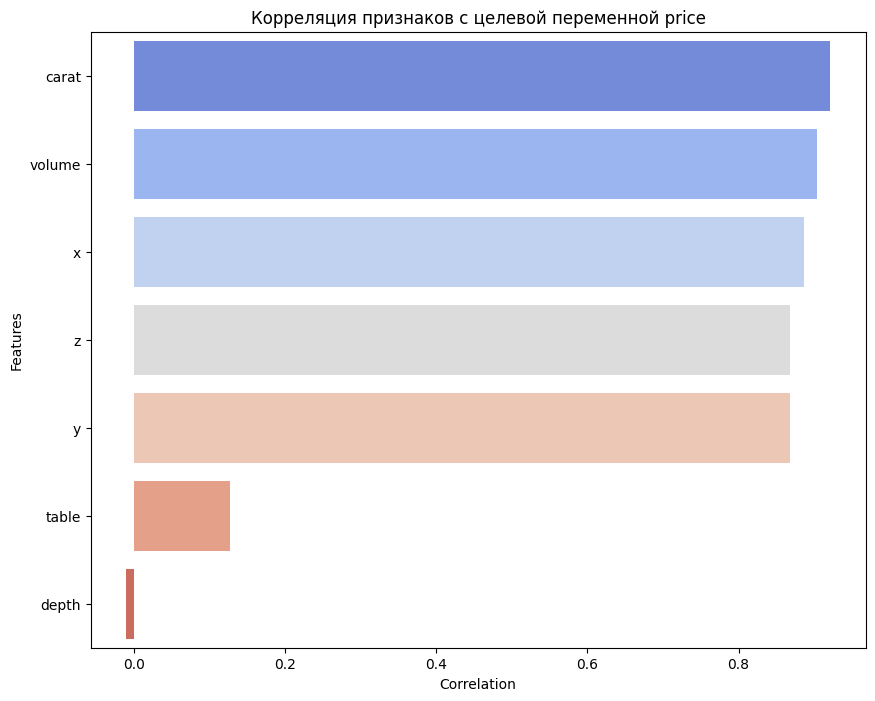

In [15]:
df_cor = df[['carat', 'depth', 'table', 'x', 'y', 'z', 'volume', 'price']]

corr = df_cor.corr()['price'].drop('price').sort_values(key=abs, ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x=corr.values, y=corr.index, palette='coolwarm')
plt.title('Корреляция признаков с целевой переменной price')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()

Очень сильная корреляция у carat и volume, больше 0.8
Очень слабая корреляция у table и depth, но они могут нести ценную информацию, поэтому оставлю
x,y,z тоже оставлю, они могут тоже нести ценную информацию, ведь будут одинаковые объемы, но разная цена, здесь и будут решать x,y,z

## Работа с категориальными признаками

C:\Users\Alexey\AppData\Local\Temp\ipykernel_8036\2163531149.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_price.values, y=corr_with_price.index, palette='coolwarm')


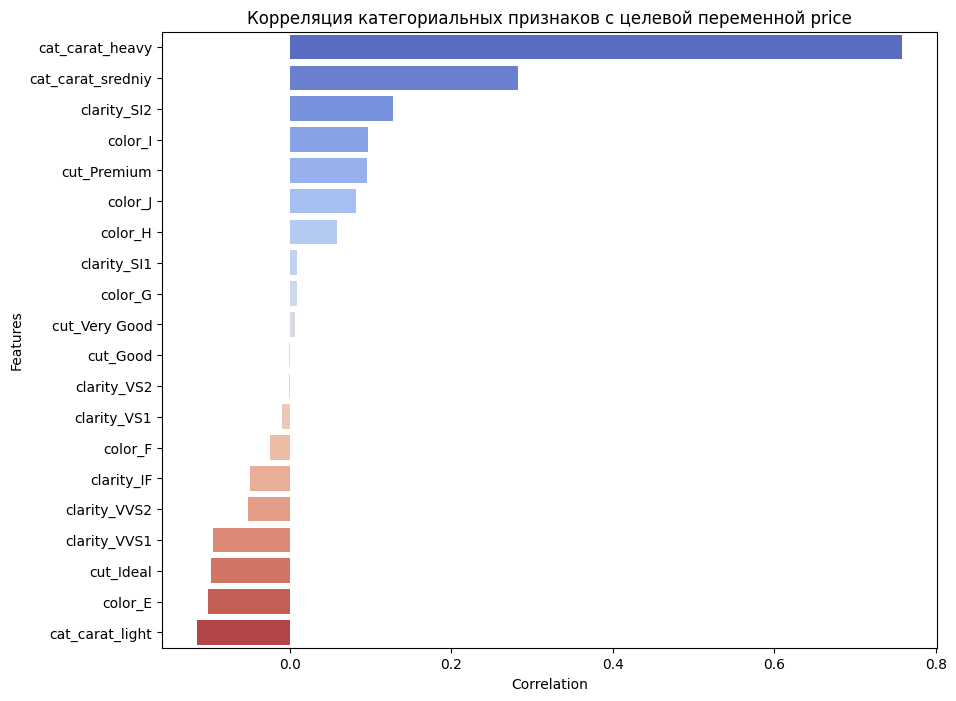

In [16]:
df_ohe = pd.get_dummies(df[['cut', 'color', 'clarity', 'cat_carat']], drop_first=True)

df_corr = pd.concat([df_ohe, df['price']], axis=1)

corr_with_price = df_corr.corr()['price'].drop('price').sort_values(ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x=corr_with_price.values, y=corr_with_price.index, palette='coolwarm')
plt.title('Корреляция категориальных признаков с целевой переменной price')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()

Хорошая корреляция только с cat_carat_heavy, осталные очень слабые

## Посмотрим распределение целевой переменной

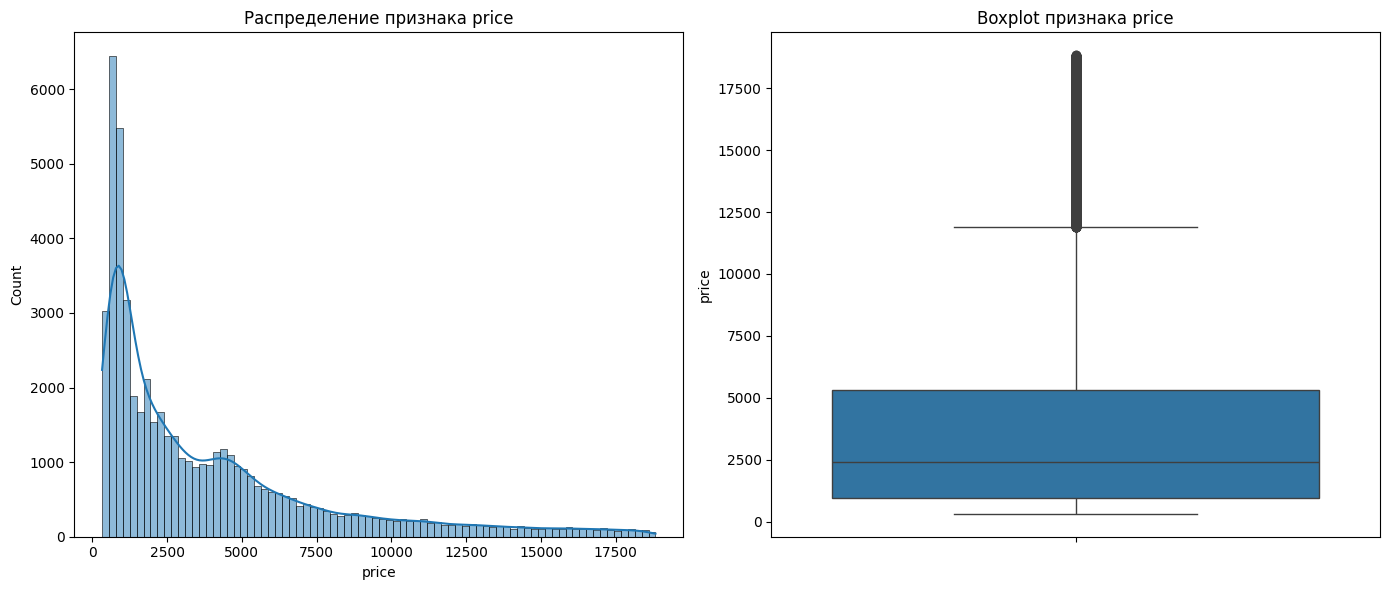

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df['price'], kde=True, ax=axes[0])
axes[0].set_title('Распределение признака price')

sns.boxplot(df['price'], ax=axes[1])
axes[1].set_title('Boxplot признака price')

plt.tight_layout()
plt.show()

Очень сильный скос вправо - применим логарифмирование

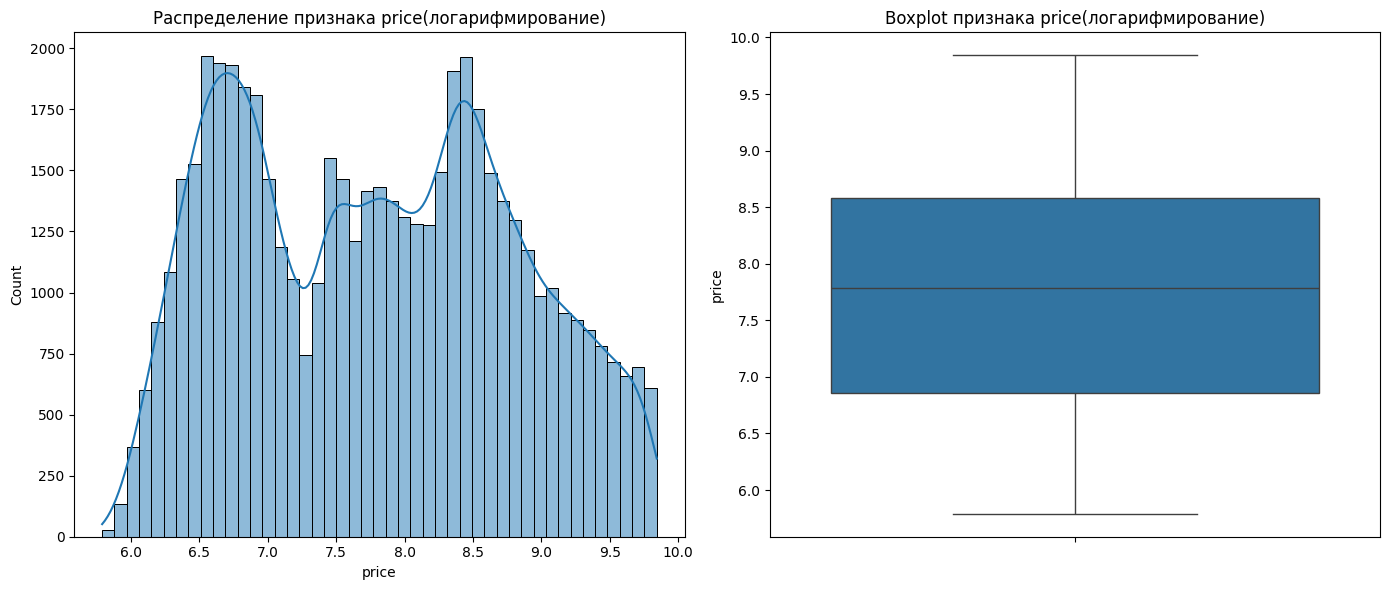

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(np.log1p(df['price']), kde=True, ax=axes[0])
axes[0].set_title('Распределение признака price(логарифмирование)')

sns.boxplot(np.log1p(df['price']), ax=axes[1])
axes[1].set_title('Boxplot признака price(логарифмирование)')

plt.tight_layout()
plt.show()

Теперь распределение стало лучше

## Подготовка данных для модели

In [20]:
X = df.drop(columns=['Unnamed: 0', 'price'])
y = df['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Построение Pipline

In [25]:
num = ['carat', 'depth', 'table', 'x', 'y', 'z', 'volume']
cat = ['cut', 'color', 'clarity', 'cat_carat']

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('qtf', QuantileTransformer(output_distribution='normal', n_quantiles=1000, subsample=1_000_000)),
    ('scaler', StandardScaler()),
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', num_pipe, num),
    ('cat', cat_pipe, cat),
])

lr_model = TransformedTargetRegressor(
    regressor=Pipeline([('prep', preprocess), ('lr', LinearRegression())]),
    func=np.log1p,
    inverse_func=np.expm1
)

In [27]:
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_val)

mae  = mean_absolute_error(y_val, pred)
rmse = np.sqrt(mean_squared_error(y_val, pred))
r2   = r2_score(y_val, pred)
print(f"MAE: {mae:.2f}  RMSE: {rmse:.2f}  R2: {r2:.4f}")

MAE: 458.07  RMSE: 865.09  R2: 0.9533


In [28]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', num_pipe, num),
    ('cat', cat_pipe, cat),
])

rf_model = Pipeline([
    ('prep', preprocess),
    ('rf', RandomForestRegressor(
        n_estimators=600,
        max_depth=None,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)

print('[RF] MAE :', mean_absolute_error(y_val, rf_pred))
print('[RF] RMSE:', np.sqrt(mean_squared_error(y_val, rf_pred)))
print('[RF] R2  :', r2_score(y_val, rf_pred))

[RF] MAE : 264.0818714695762
[RF] RMSE: 546.7124272220121
[RF] R2  : 0.9813563252178904


In [29]:
xgb_model = Pipeline([
    ('prep', preprocess),
    ('xgb', XGBRegressor(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        n_jobs=-1,
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)

print('[XGB] MAE :', mean_absolute_error(y_val, xgb_pred))
print('[XGB] RMSE:', np.sqrt(mean_squared_error(y_val, xgb_pred)))
print('[XGB] R2  :', r2_score(y_val, xgb_pred))

[XGB] MAE : 263.65277099609375
[XGB] RMSE: 541.5552545678049
[XGB] R2  : 0.9817063808441162
